In [ ]:
CONFIG_FILE = "config/benchmark/qiskit_rq.json"
REPO_NAME: str = "Qiskit/qiskit"
ARTIFACT_FOLDER: str = "../data/test_augmentation/014/qiskit"
FOLDER_WITH_TESTS: str = "target_gen_base_dynamic_test_context_fb_integrated"

# Token Costs

Run this notebook via papermill `pip install papermill` to execute it with the specified parameters. Example command:

```bash
papermill token_cost_stats.ipynb token_cost_stats_qiskit.ipynb \
    -p CONFIG_FILE "config/benchmark/qiskit_rq.json" \
    -p REPO_NAME "Qiskit/qiskit" \
    -p ARTIFACT_FOLDER "../data/test_augmentation/014/qiskit" \
    -p FOLDER_WITH_TESTS "target_gen_base_dynamic_test_context_fb_integrated"
```
Replace `token_cost_stats_qiskit.ipynb` with the desired output file name. Adjust the parameters as needed for your analysis.

In [48]:
from multiprocessing import Pool
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path
import numpy as np
import seaborn as sns
import requests
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [50]:
# read the config file to get the list of PRs benchmarked
import yaml
import json
import os
from pathlib import Path

PREFIX = Path("../")


with open(PREFIX / CONFIG_FILE, "r") as f:
    pr_file = json.load(f)
    pr_list = pr_file["projects"][REPO_NAME]["pr_numbers"]
    print("Number of PRs used for benchmarking:", len(pr_list))
    print("PR list:", pr_list)

Number of PRs used for benchmarking: 50
PR list: [12369, 12380, 12474, 12483, 12495, 12561, 12579, 12608, 12705, 12767, 12770, 12775, 12776, 12785, 12799, 12814, 12825, 12848, 12898, 12904, 12927, 12952, 12963, 12979, 13214, 13251, 13343, 13357, 13375, 13450, 13530, 13531, 13539, 13596, 13601, 13624, 13643, 13704, 13801, 13922, 14024, 14132, 14143, 14217, 14275, 14353, 14381, 14417, 14529, 14543]


In [51]:

sys.path.append(os.path.abspath(os.path.join('..')))


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        data["pr_number"] = data["_filename"].split(".")[0]
        return data


def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)

# Token Cost Analysis

In [52]:
target_folder = ARTIFACT_FOLDER

dir_dev_discussion = os.path.join(
    target_folder, "dev_discussion")
df_dev_discussion = read_all_jsons(dir_dev_discussion)
df_dev_discussion["stage"] = "dev_discussion"

dir_augmented_discussion = os.path.join(
    target_folder, "augmented_discussion")
df_augmented_discussion = read_all_jsons(dir_augmented_discussion)
df_augmented_discussion["stage"] = "augmented_discussion"

dir_test_cases = os.path.join(
    target_folder,
    f"test_cases/{FOLDER_WITH_TESTS}")
print(f"Reading test cases from {dir_test_cases}"
      )
test_records = []
for subdir in os.listdir(dir_test_cases):
    pr_folder = os.path.join(dir_test_cases, subdir)
    # print(f"Processing PR folder: {pr_folder}")
    # read all the json ending with _origin.json (recursively)
    json_files = [f for f in os.listdir(
        pr_folder) if f.endswith('_origin.json')]
    n_origin_files = len(json_files)
    # print(f"Found {n_origin_files} origin files in {pr_folder}")
    for json_file in json_files:
        file_path = os.path.join(pr_folder, json_file)
        with open(file_path, 'r') as file:
            data = json.load(file)
            data["_filename"] = json_file
            data["pr_number"] = int(subdir)
        test_records.append(data)
df_test_cases = pd.DataFrame(test_records)
df_test_cases["stage"] = "test_cases"


df_all = pd.concat(
    [df_dev_discussion, df_augmented_discussion, df_test_cases],
    ignore_index=True
)
# convert pr_number to int for consistency
df_all["pr_number"] = df_all["pr_number"].astype(int)
# keep only the PRs that are in the fully logged PRs
df_all = df_all[df_all["pr_number"].isin(pr_list)]

df_all

Reading test cases from ../data/test_augmentation/014/qiskit/test_cases/target_gen_base_dynamic_test_context_fb_integrated


,page_url,content_as_markdown,links,summaries,provenance,token_usage,_filename,pr_number,stage,diff_content,...,test_class,test_method,dynamic_test_context,dynamic_failed,target_func,dynamic_test_context_unavailable,test_case,runtime_error_message,fixed_test_case,num_feedback_attempts
0,https://github.com/Qiskit/qiskit/pull/14381,"\nRevert ""Port star_preroute to rust"" by mtrei...","[https://github.com/why-github, /Qiskit/qiskit...",[This pull request reverts the previous attemp...,[https://github.com/Qiskit/qiskit/pull/14381],"[{'completion_tokens': 245, 'prompt_tokens': 4...",14381.json,14381,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://github.com/Qiskit/qiskit/pull/13624,"\nFix phase of `pauli_list.insert(..., qubit=T...","[https://docs.github.com, /Qiskit/qiskit/label...",[This pull request (PR #13624) fixes a bug in ...,[https://github.com/Qiskit/qiskit/pull/13624],"[{'completion_tokens': 251, 'prompt_tokens': 4...",13624.json,13624,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://github.com/Qiskit/qiskit/pull/13539,\n`StabilizerState.expectation_value` can also...,"[/, /resources/articles/devops, #issue-2725336...",[This pull request adds the capability for `St...,[https://github.com/Qiskit/qiskit/pull/13539],"[{'completion_tokens': 172, 'prompt_tokens': 3...",13539.json,13539,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://github.com/Qiskit/qiskit/pull/12705,\nAvoid Python op creation in BasisTranslator ...,"[https://resources.github.com, https://github....",[This pull request (PR #12705) updates the Bas...,[https://github.com/Qiskit/qiskit/pull/12705],"[{'completion_tokens': 232, 'prompt_tokens': 3...",12705.json,12705,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://github.com/Qiskit/qiskit/pull/14217,\nBug fixes in Solovay Kitaev Decomposition by...,[/Qiskit/qiskit/pull/14217/commits/cea0a0e96dd...,[This pull request (PR #14217) addresses sever...,[https://github.com/Qiskit/qiskit/pull/14217],"[{'completion_tokens': 268, 'prompt_tokens': 8...",14217.json,14217,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 171, 'prompt_tokens': 1...",test_15_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,TestQFTGate,"from pytest import mark, fixture\n'Test librar...",True,False,QFTGate.__array__,False,import unittest\nimport numpy as np\nfrom qisk...,"Command '['timeout', '120', 'coverage', 'run',...",import unittest\nimport numpy as np\nfrom qisk...,4.0
857,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 191, 'prompt_tokens': 1...",test_8_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,TestQFTGate,"from pytest import mark, fixture\n'Test librar...",True,False,QFTGate.__array__,False,import unittest\nfrom qiskit.circuit.library i...,"Command '['timeout', '120', 'coverage', 'run',...",import unittest\nfrom qiskit.circuit.library i...,2.0
858,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 168, 'prompt_tokens': 1...",test_3_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,TestQFTGate,"from pytest import mark, fixture\n'Test librar...",True,False,QFTGate.__array__,False,import numpy as np\nimport unittest\nfrom qisk...,"Command '['timeout', '120', 'coverage', 'run',...",import numpy as np\nimport unittest\nfrom qisk...,3.0
859,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 199, 'prompt_tokens': 1...",test_2_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,TestQFTGate,"from pytest import mark, fixture\n'Test librar...",True,False,QFTGate.__array__,False,import unittest\nimpo

In [53]:
# print unqiue stages
print("Unique stages in df_all:")
print(df_all['stage'].unique())

Unique stages in df_all:
['dev_discussion' 'augmented_discussion' 'test_cases']


In [54]:
# for each row, check the col token_usage
# it is a list of dicts, each dict has keys: completion_tokens, prompt_tokens, total_tokens
# for each of the three keys sum the values and create three new columns:
def extract_token_usage(row: pd.Series) -> pd.Series:
    if isinstance(row['token_usage'], list):
        total_completion_tokens = sum(
            item.get('completion_tokens', 0) for item in row['token_usage'])
        total_prompt_tokens = sum(
            item.get('prompt_tokens', 0) for item in row['token_usage'])
        total_tokens = sum(
            item.get('total_tokens', 0) for item in row['token_usage'])
    else:
        total_completion_tokens = 0
        total_prompt_tokens = 0
        total_tokens = 0

    return pd.Series({
        'total_completion_tokens': total_completion_tokens,
        'total_prompt_tokens': total_prompt_tokens,
        'total_tokens': total_tokens
    })


# Apply the function to each row and create new columns
df_token_usage = df_all.progress_apply(extract_token_usage, axis=1)
# Concatenate the new columns with the original DataFrame
df_all_w_token_usage = pd.concat([df_all, df_token_usage], axis=1)

  0%|          | 0/839 [00:00<?, ?it/s]

In [55]:
df_all_w_token_usage

,page_url,content_as_markdown,links,summaries,provenance,token_usage,_filename,pr_number,stage,diff_content,...,dynamic_failed,target_func,dynamic_test_context_unavailable,test_case,runtime_error_message,fixed_test_case,num_feedback_attempts,total_completion_tokens,total_prompt_tokens,total_tokens
0,https://github.com/Qiskit/qiskit/pull/14381,"\nRevert ""Port star_preroute to rust"" by mtrei...","[https://github.com/why-github, /Qiskit/qiskit...",[This pull request reverts the previous attemp...,[https://github.com/Qiskit/qiskit/pull/14381],"[{'completion_tokens': 245, 'prompt_tokens': 4...",14381.json,14381,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,4095,4340
1,https://github.com/Qiskit/qiskit/pull/13624,"\nFix phase of `pauli_list.insert(..., qubit=T...","[https://docs.github.com, /Qiskit/qiskit/label...",[This pull request (PR #13624) fixes a bug in ...,[https://github.com/Qiskit/qiskit/pull/13624],"[{'completion_tokens': 251, 'prompt_tokens': 4...",13624.json,13624,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,4949,5200
2,https://github.com/Qiskit/qiskit/pull/13539,\n`StabilizerState.expectation_value` can also...,"[/, /resources/articles/devops, #issue-2725336...",[This pull request adds the capability for `St...,[https://github.com/Qiskit/qiskit/pull/13539],"[{'completion_tokens': 172, 'prompt_tokens': 3...",13539.json,13539,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172,3211,3383
3,https://github.com/Qiskit/qiskit/pull/12705,\nAvoid Python op creation in BasisTranslator ...,"[https://resources.github.com, https://github....",[This pull request (PR #12705) updates the Bas...,[https://github.com/Qiskit/qiskit/pull/12705],"[{'completion_tokens': 232, 'prompt_tokens': 3...",12705.json,12705,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232,3917,4149
4,https://github.com/Qiskit/qiskit/pull/14217,\nBug fixes in Solovay Kitaev Decomposition by...,[/Qiskit/qiskit/pull/14217/commits/cea0a0e96dd...,[This pull request (PR #14217) addresses sever...,[https://github.com/Qiskit/qiskit/pull/14217],"[{'completion_tokens': 268, 'prompt_tokens': 8...",14217.json,14217,dev_discussion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268,8870,9138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 171, 'prompt_tokens': 1...",test_15_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,False,QFTGate.__array__,False,import unittest\nimport numpy as np\nfrom qisk...,"Command '['timeout', '120', 'coverage', 'run',...",import unittest\nimport numpy as np\nfrom qisk...,4.0,1354,6742,8096
857,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 191, 'prompt_tokens': 1...",test_8_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,False,QFTGate.__array__,False,import unittest\nfrom qiskit.circuit.library i...,"Command '['timeout', '120', 'coverage', 'run',...",import unittest\nfrom qiskit.circuit.library i...,2.0,886,4408,5294
858,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 168, 'prompt_tokens': 1...",test_3_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,False,QFTGate.__array__,False,import numpy as np\nimport unittest\nfrom qisk...,"Command '['timeout', '120', 'coverage', 'run',...",import numpy as np\nimport unittest\nfrom qisk...,3.0,1137,5629,6766
859,NaN,NaN,NaN,NaN,"[{'pytest_failed': True, 'num_lines_added': 0}...","[{'completion_tokens': 199, 'prompt_tokens': 1...",test_2_origin.json,12979,test_cases,diff --git a/qiskit/circuit/library/basis_chan...,...,False,QFTGate.__array__,False,import unittest\nimport numpy as np\nfrom qisk...,"Command '['timeout', '120', 'coverage', 'run',...",import unittest\nimport numpy as np\nfrom qisk...,2.0,876,4361,5237


Number of PRs with all stages: 48


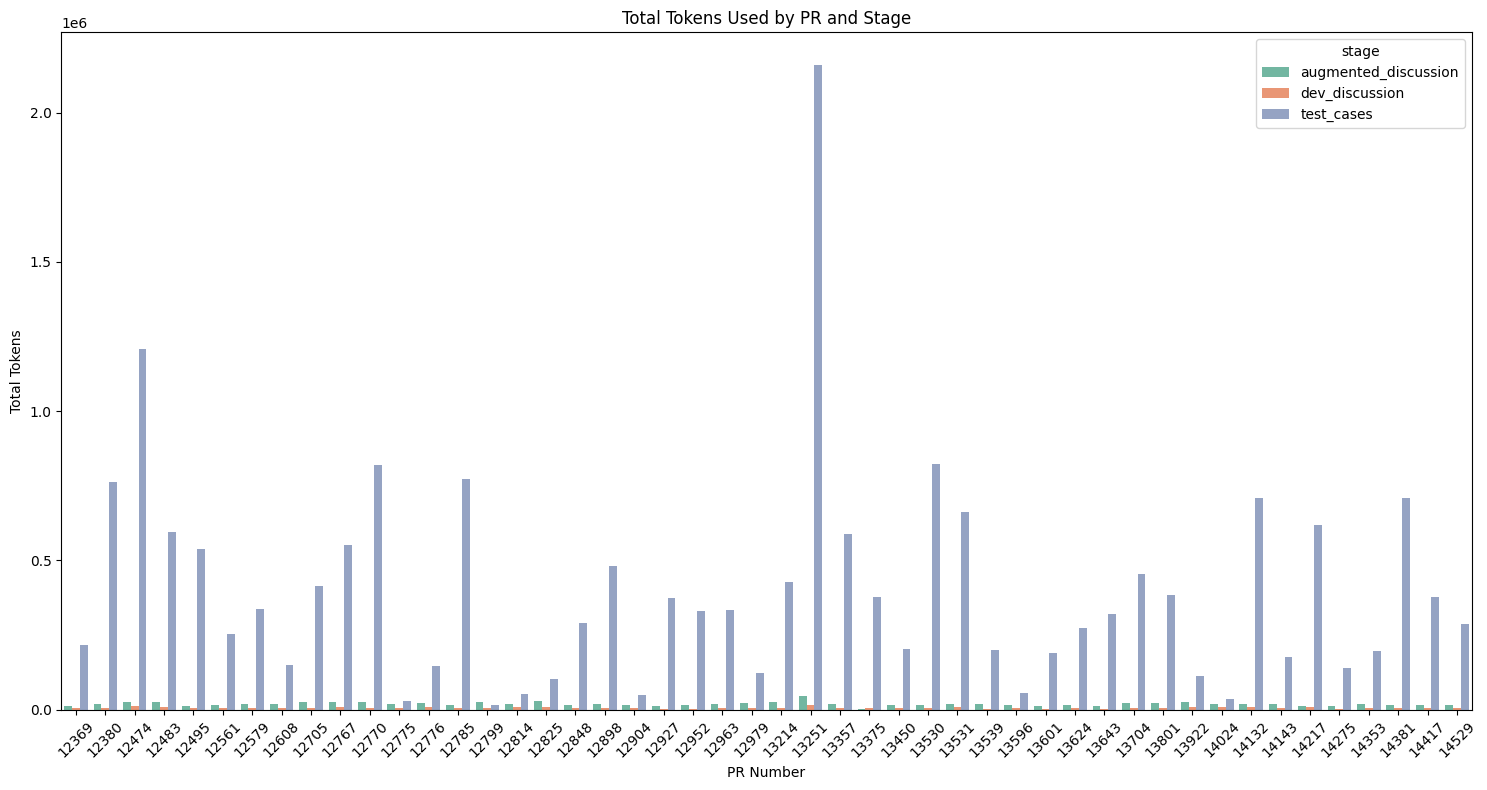

In [56]:
# keep only the pr_number, stage, total_completion_tokens, total_prompt_tokens, total_tokens
df_all_w_token_usage["pr_number"] = df_all_w_token_usage["pr_number"].astype(
    str)
df_all_summary_cost = df_all_w_token_usage[[
    'pr_number', 'stage', 'total_completion_tokens',
    'total_prompt_tokens', 'total_tokens']]

# keep only the prs that have at least one row in each of the three stages:
# dev_discussion, augmented_discussion, test_cases
prs_with_all_stages = df_all_summary_cost.groupby('pr_number').filter(
    lambda x: set(x['stage']) ==
    {'dev_discussion', 'augmented_discussion', 'test_cases'})
print(
    f"Number of PRs with all stages: {len(prs_with_all_stages['pr_number'].unique())}")

# group by pr_number and stage
df_grouped = prs_with_all_stages.groupby(
    ['pr_number', 'stage']).sum().reset_index()

plt.figure(figsize=(15, 8))

# Create grouped bar plot
plot = sns.barplot(
    data=df_grouped,
    x='pr_number',
    y='total_tokens',
    hue='stage',
    palette='Set2'
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.title('Total Tokens Used by PR and Stage')
plt.xlabel('PR Number')
plt.ylabel('Total Tokens')

# Adjust layout to prevent label cutoff
plt.tight_layout()

,completion_tokens,prompt_tokens,total_tokens,model_name,stage_name,timestamp,readable_date
0,245,4095,4340,openai/gpt-4o-mini,GeneratePRSummary,1.752252e+09,2025-07-11T16:44:48.603589+00:00
1,251,4949,5200,openai/gpt-4o-mini,GeneratePRSummary,1.752253e+09,2025-07-11T16:56:09.335209+00:00
2,172,3211,3383,openai/gpt-4o-mini,GeneratePRSummary,1.752253e+09,2025-07-11T16:58:47.578339+00:00
3,232,3917,4149,openai/gpt-4o-mini,GeneratePRSummary,1.752180e+09,2025-07-10T20:42:05.990055+00:00
4,268,8870,9138,openai/gpt-4o-mini,GeneratePRSummary,1.752252e+09,2025-07-11T16:44:48.898402+00:00
...,...,...,...,...,...,...,...
4358,244,1200,1444,openai/gpt-4o-mini,FixRuntimeErrors,1.752154e+09,2025-07-10T13:27:24.820311+00:00
4359,170,1141,1311,openai/gpt-4o-mini,SummarizeUncoveredLines,1.752155e+09,2025-07-10T13:47:49.312961+00:00
4360,188,897,1085,openai/gpt-4o-mini,GenerateTestCases,1.752155e+09,2025-07-10T13:47:53.074804+00:00
4361,238,1101,1339,openai/gpt-4o-mini,FixRuntimeErrors,1.752155e+09,2025-07-10T13:48:12.647983+00:00


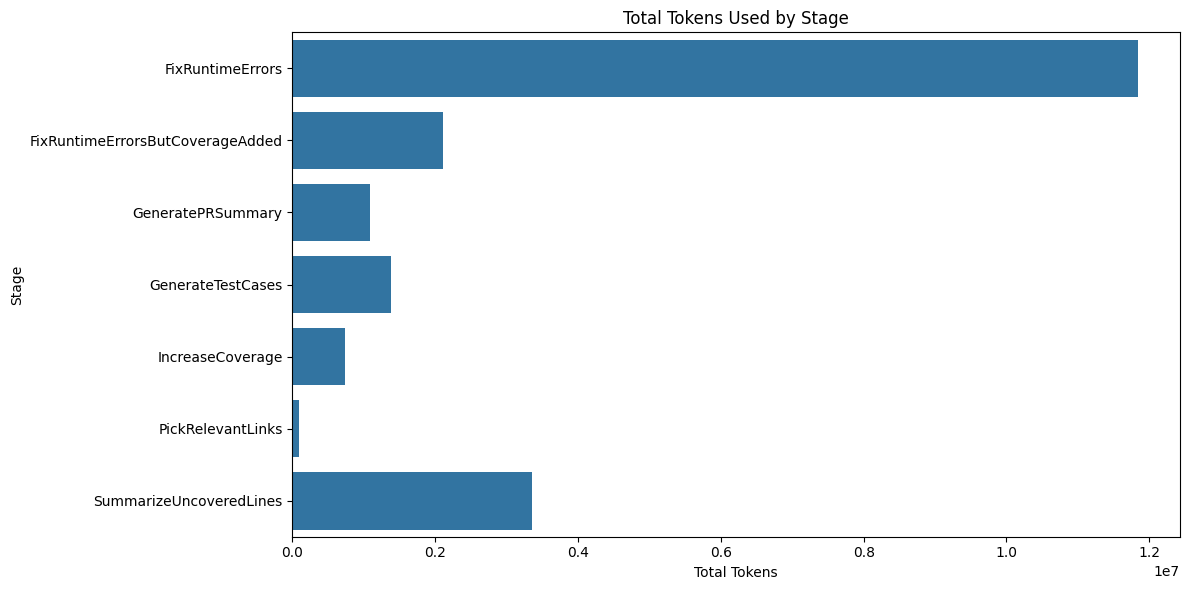

In [57]:
# extract all token usage dicts form all the rows and make a single list
all_token_usage = []
for token_usage in df_all_w_token_usage['token_usage']:
    if isinstance(token_usage, list):
        all_token_usage.extend(token_usage)
# Create a DataFrame from the list of token usage dicts
df_only_token_usage = pd.DataFrame(all_token_usage)

# show cumulative token usage for each stage_name
# Group by stage_name and sum the tokens
stage_totals = df_only_token_usage.groupby('stage_name').agg({
    'completion_tokens': 'sum',
    'prompt_tokens': 'sum',
    'total_tokens': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
# Changed x and y to make horizontal
sns.barplot(data=stage_totals, y='stage_name', x='total_tokens')
plt.title('Total Tokens Used by Stage')
plt.xlabel('Total Tokens')
plt.ylabel('Stage')
plt.tight_layout()

df_only_token_usage

In [ ]:
# Define the cost dictionary for models
MODEL_COST = {
    'openai/gpt-4o-mini': {
        'prompt_tokens_cost_per_million': 0.15,
        'completion_tokens_cost_per_million': 0.60
    }
}

# Function to calculate cost for a single row


def calculate_cost(row: pd.Series) -> float:
    model_name = row['model_name']
    if model_name in MODEL_COST:
        prompt_cost = (
            row['prompt_tokens'] / 1_000_000) * MODEL_COST[model_name]['prompt_tokens_cost_per_million']
        completion_cost = (
            row['completion_tokens'] / 1_000_000) * MODEL_COST[model_name][
            'completion_tokens_cost_per_million']
        return prompt_cost + completion_cost
    return 0.0


# Apply the cost calculation function to each row
df_only_token_usage['cost'] = df_only_token_usage.progress_apply(
    calculate_cost, axis=1)

# Calculate total cost per PR
total_cost_per_pr = df_only_token_usage.groupby('stage_name')['cost'].sum()
print("Total cost per PR:")
print(total_cost_per_pr)

# Calculate total cost for all experiments
total_experiment_cost = df_only_token_usage['cost'].sum()
print(f"Total cost for all experiments: ${total_experiment_cost:.2f}")

# Average cost per PR
average_cost_per_pr = total_experiment_cost / len(pr_list)
print(f"Average cost per PR: ${average_cost_per_pr:.2f}")

project_name = REPO_NAME.split("/")[1]
# Save the DataFrame to a CSV file
df_only_token_usage.to_csv(f"{project_name}_token_usage.csv", index=False)

  0%|          | 0/4363 [00:00<?, ?it/s]

Total cost per PR:
stage_name
FixRuntimeErrors                    5.695804
FixRuntimeErrorsButCoverageAdded    0.962441
GeneratePRSummary                   0.475305
GenerateTestCases                   0.780703
IncreaseCoverage                    0.371358
PickRelevantLinks                   0.047483
SummarizeUncoveredLines             1.532152
Name: cost, dtype: float64
Total cost for all experiments: $9.87
Average cost per PR: $0.20
